## Manually Label Project Metaphors

Randomly select projects and extract potential metaphors. Manually label whether the presented text fragment contains a metaphorical cancer-related phrase. Focus given to the underlined keyword token.

### TODO

o More labeled data

o Cancer as a subject or object. Does cancer fight the patient, or the other way around?

In [1]:
import os.path as op # for data file imports
from datetime import datetime # for timing user actions

import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm # for progress bars

%config InlineBackend.figure_format = 'retina' # for better looking plots

import re # for locating keywords

In [2]:
# data files of interest are in the /processed directory
DATA_PROCESSED = '../data/processed'

# http://ozzmaker.com/add-colour-to-text-in-python/
STYLE = '\033[41m' # red bg
END = '\033[0m'

### Load Projects and Labeled Keywords

In [3]:
# projects without any metaphor features
all_projects = pd.read_csv(op.join(DATA_PROCESSED, 'combined_projects.csv'))

# fragments that have been labeled for metaphoricity
labeled = pd.read_csv(op.join(DATA_PROCESSED, 'labeled.csv'))

# labeling times list
times = np.loadtxt("labeling_times.txt").tolist()

print(f'Total Projects DF: {len(all_projects):,}')
print(f'Total Labeled Keywords DF: {len(labeled):,}')
print(f'Total Unique Projects Labeled: {labeled.project_id.nunique():,}')

Total Projects DF: 10,096
Total Labeled Keywords DF: 12,384
Total Unique Projects Labeled: 6,673


### Stats

In [5]:
kickstarter_mask = all_projects['source'] == 'kickstarter'
gofundme_mask = all_projects['source'] == 'gofundme'
# portion of all projects that are from each source
print(f'Kickstarter vs. GFM:\t {kickstarter_mask.mean()*100:.2f}% / {gofundme_mask.mean()*100:.2f}%')

# expected number of metaphors present per campaign
ixs = all_projects.loc[kickstarter_mask, 'id'].values
filt = labeled.loc[labeled['project_id'].isin(ixs), 'metaphorical'].dropna()

print(f'Metaphors per Kickstarter project: {sum(filt == True) / len(ixs):.3f}')

# expected number of metaphors present per campaign
ixs = all_projects.loc[gofundme_mask, 'id'].values
filt = labeled.loc[labeled['project_id'].isin(ixs), 'metaphorical'].dropna()

print(f'Metaphors per GFM project: {sum(filt == True) / len(ixs):.3f}')


p_hat = filt.mean()
del ixs, filt

print(f'Sample proportion of GFM keywords that are metaphorical: {p_hat*100:.2f}%')

Kickstarter vs. GFM:	 4.05% / 95.95%
Metaphors per Kickstarter project: 0.861
Metaphors per GFM project: 0.847
Sample proportion of GFM keywords that are metaphorical: 93.19%


In [6]:
ixs = all_projects.loc[gofundme_mask, 'id'].values
filt = labeled.loc[labeled['project_id'].isin(ixs), 'metaphorical'].dropna()

print(f"Total Keywords: {labeled['project_id'].isin(ixs).sum():,}")
print(f"Total Projects: {all_projects['id'].isin(labeled['project_id']).sum():,}")
print(f"Proportion Metaphorical Keywords: {labeled.loc[labeled['project_id'].isin(ixs), 'metaphorical'].dropna().sum() / labeled['project_id'].isin(ixs).sum():.3f}")

Total Keywords: 11,107
Total Projects: 6,317
Proportion Metaphorical Keywords: 0.739


In [7]:
labeled.shape

labeled.loc[labeled['project_id'].isin(ixs), "metaphorical"].dropna().sum()

8209

https://metaphor.icsi.berkeley.edu/pub/en/index.php/Metaphor:CANCER_IS_A_JOURNEY

In [50]:
# these are ordered lists - since we search in order the lemma comes last (so not to catch non-lemma'd words)

BATTLE_WORDS = ['fights', 'fighting', 'fight', 'fought', 
                'battles', 'battled', 'battling', 'battle', 
                'war', 
                'beating', 'beats', 'beaten', 'beat', 
                'enemy', 
                'defeat', 
                'winning', 'win', 
                'combat']

JOURNEY_WORDS = ['path', 'journey', 'road', 'rollercoaster']

FORCE_WORDS = ['forced', 'forcing', 'force', 
               'lava', 'flood', 'volcano', 'waves', 'wave', 'drown', 'storm',
               'disaster', 'rivers', 'river', 'rain']

window = 80

# Manually Label Metaphors

In [51]:
def find_keywords(text, source, source_type):
    '''
    Search `text` for all instances of keywords in `source`.
    '''
    if not isinstance(text, float):
        for kw in source:
            exp = r'\W(' + kw + ')\W'
            for kw_match in re.finditer(exp, text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)

                prompt = text[start:kw_match.start()+1] + STYLE + text[kw_match.start()+1:kw_match.end()-1] + END + text[kw_match.end()-1:end]

                yield prompt, {'fragment': text[start:end], 
                               'char_location': float(kw_match.start()),
                               'kw_start': int(kw_match.start()) - int(start) + 1,
                               'type': source_type, 
                               'keyword': kw}
            
def metaphorical_response(total, current):
    res = input('Is this a cancer related metaphor? ')
    if len(res) == 2:
        pr = res[1]
        res = res[0]
        if pr == 'r':
            print(f"{current / total * 100:.2f}%")
            
    return res == 'y'

def exists_with_keyword(source, ix, char_location):
    '''
    Does the given project, with ID `ix`, exist in `source` with a keyword at `char_location`?
    '''
    return char_location in source.loc[source['project_id'] == ix, 'char_location'].values
    
def exists_without_keywords(source, ix):
    '''
    Does the given project, with ID `ix`, exist in `source` as a null (meaning, it has been seen previously
    and labeled as having no keywords)?
    '''
    locs = source.loc[source['project_id'] == ix, 'char_location']
    return len(locs) == 1 and sum(locs.isnull()) == 1

def unlabeled_projects():
    '''
    Return all projects that have not been examined for metaphors
    '''
    return all_projects.loc[~all_projects['id'].isin(labeled['project_id'])]

def predict_instance(instance):
    features = make_features_of_instance(pd.Series(instance))
    frag = elmo.embed_sentence(pad(instance['fragment'], int(instance['kw_start'])))[2]
    
    if instance['type'] == 'battle':
        return (battle_model.predict([[features], [frag]]) > 0.5).astype(bool)[0][0]
    
    return (journey_model.predict([[features], [frag]]) > 0.5).astype(bool)[0][0]

def count_remaining_keywords(projects):
    '''
    Search through the given project list and count the number of remaining keywords. Note that this is
    basically O(n*w) with n projects and w words per project.
    '''
    c = 0
    for project in projects[['id', 'text']].itertuples():
        for source, key in [(FORCE_WORDS, 'force'), (BATTLE_WORDS, 'battle'), (JOURNEY_WORDS, 'journey')]:
            for prompt, result in find_keywords(project.text, source, key):

                if not exists_with_keyword(labeled, project.id, result['char_location']):                    
                    c += 1
                
    return c

In [83]:
labeled.loc[(labeled['type'] == 'journey') & (labeled['metaphorical'] == False)].sample(5)['fragment'].values

array(['ting footage shot by\nAlthea and Zukaia in the weeks leading up to and during the journey.\xa0 (I taught them how to use a flipcam and they\nhave been filming since March.)\xa0 ',
       "eat with a purpose, it's time to Fight Cancer With a Fork! \xa0Please join me on my journey and thank you for being apart of change.",
       '.)\xa0It wasn’t until my OB/GYN suggested I get a colonoscopy that I started on the path to learning the truth. I was turning 50, it was time to get one anyway. \xa0I put i',
       'd for other families going through cancer as well. You can find out more about A Journey to Heal here.  Limited edition 11"x14" fine art linocut prints. Hand inked and p',
       'First of all we want to thank everyone for showing support to Finn during the journey of his shoulder, it really means so much to us. Finn is a 10 month old St. Berna'],
      dtype=object)

In [84]:
up = all_projects.loc[all_projects['id'].isin(labeled['project_id'])] #unlabeled_projects()

c = total = int(input(f'N (max: {count_remaining_keywords(up):,}): '))

tp, fp, nan, projects = 0, 0, 0, 0

start = datetime.now()
        
for project in up.sample(frac=1).itertuples():
    
    print()
    print(f'PROJECT {project.name}')
    
    projects += 1
    
    keyword_found = False
    
    for source, key in [(FORCE_WORDS, 'force'), (BATTLE_WORDS, 'battle'), (JOURNEY_WORDS, 'journey')]:
        for prompt, result in find_keywords(project.text, source, key):
            
            if exists_with_keyword(labeled, project.id, result['char_location']):
                continue
            
            if exists_without_keywords(labeled, project.id):
                pass
#                 labeled = labeled.loc[labeled['project_id'] != project.id]
                
            c -= 1
            keyword_found = True
                        
            result['project_id'] = project.id
        
            print(prompt)

            if metaphorical_response(total, total - c):
                result['metaphorical'] = True
                tp += 1
            else:
                result['metaphorical'] = False
                fp += 1

            labeled = labeled.append(result, ignore_index=True)
                
    # if no metaphor existed and this isn't already known
#     if not keyword_found and not exists_without_keywords(labeled, project.id):

    if not keyword_found and project.id not in labeled['project_id'].values:
        result = {'project_id': project.id,
                    'fragment': np.nan, 
                    'char_location': np.nan,
                    'kw_start': np.nan,
                    'type': 'none',
                    'metaphorical': np.nan,
                    'keyword': np.nan}
        
        labeled = labeled.append(result, ignore_index=True)  
        nan += 1
        print('No metaphors found')
    
    if c <= 0:
        break
        
end = datetime.now()

times.append([(end - start).total_seconds(), projects])

print(f'True Positives: {tp} - False Positives: {fp} - Non-existent: {nan} - Projects: {projects}')

KeyboardInterrupt: 

In [42]:
np.unique(labeled.loc[labeled['type'] == 'force', 'keyword'], return_counts=True)

(array(['disaster', 'drown', 'flood', 'force', 'forced', 'forcing', 'rain',
        'river', 'rivers', 'storm', 'waves'], dtype=object),
 array([ 5,  2,  6, 44, 79, 13,  3,  8,  2, 26,  6]))

In [139]:
# for ix in ixs:
#     kp = labeled.loc[(labeled['project_id'] == ix) & (labeled['type'] != 'none')]
#     print(labeled.loc[(labeled['project_id'] == ix)])
#     print(kp)
#     labeled = labeled.loc[labeled['project_id'] != ix]
#     labeled = labeled.append(kp)

In [133]:
# ixs = []
# for ix, g in labeled.groupby('project_id'):
#     if 'none' in g['type'].values and len(g['type'].values) > 1:
#         ixs.append(ix)

Total time remaining: 1.068 hours


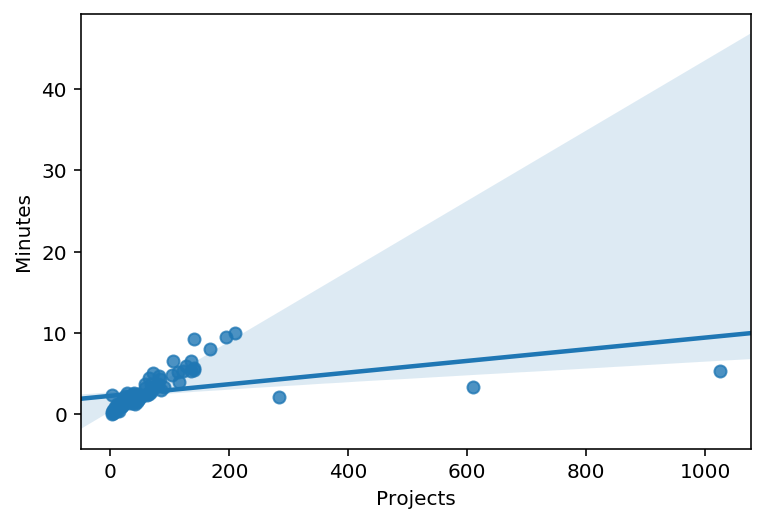

In [28]:
nptimes = np.array(times)
p = len(unlabeled_projects())
print(f"Total time remaining: {(nptimes[:, 0].sum() / nptimes[:, 1].sum()) * (1/60) * (1/60) * p:.3f} hours")

sns.regplot(x=nptimes[:, 1], y=nptimes[:, 0] / 60, order=1)
plt.ylabel('Minutes')
plt.xlabel('Projects')

np.savetxt("labeling_times.txt", nptimes)

Duplicates: 0
Total metaphor keywords: 8817


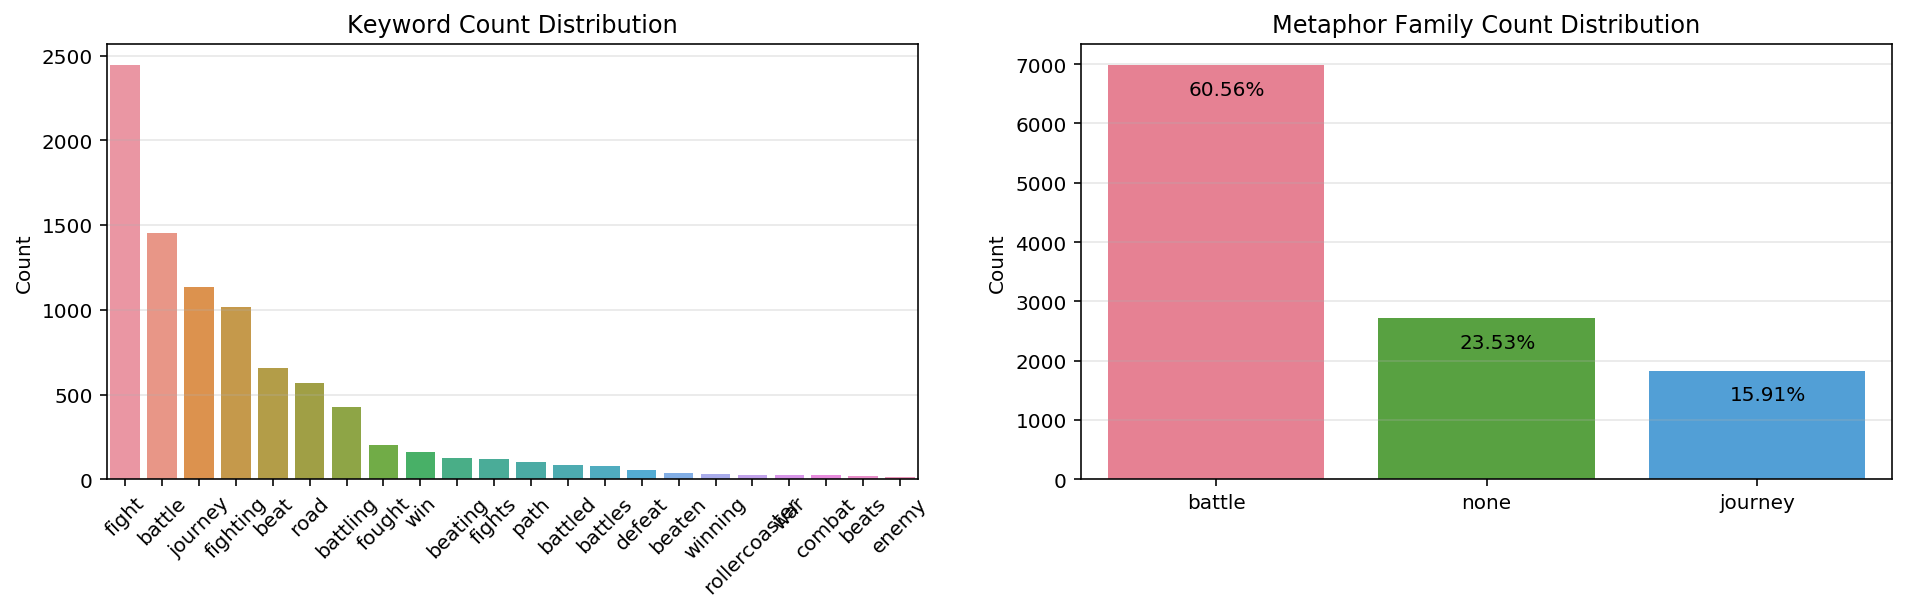

In [75]:
print(f'Duplicates: {labeled.duplicated().sum()}')
labeled = labeled.drop_duplicates()

print(f'Total metaphor keywords: {len(labeled.loc[labeled["metaphorical"] == True])}')

plt.subplots(1, 2, figsize=(16,4))

plt.subplot(1,2,1)
vc = labeled.loc[labeled['metaphorical'] == True, 'keyword'].value_counts();
sns.barplot(vc.index, vc.values)
plt.title('Keyword Count Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1,2,2)
vc = labeled.loc[labeled['metaphorical'] != False, 'type'].value_counts()
g = sns.barplot(vc.index, vc.values, palette='husl')
plt.title('Metaphor Family Count Distribution')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)

s = sum(vc.values)
for p in g.patches:
    h = p.get_height()
    plt.text(p.get_x() + 0.3, h - 500, f'{h/s*100:.2f}%')

In [76]:
labeled.to_csv(op.join(DATA_PROCESSED, 'labeled.csv'), index=False)

# Auto-Detection

First attempt is with simple regular expressions.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
labeled_kw_exists = labeled[-1000:].dropna()
train_ixs, test_ixs = train_test_split(np.arange(len(labeled_kw_exists)), train_size=0.1, stratify=labeled_kw_exists['metaphorical'])


/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
def related_to_cancer(text):
    '''
    Does the given text contain cancer-related keywords?
    '''
    return 'cancer' in text or 'leukemia' in text or 'melanoma' in text or 'lymphoma' in text

def regex_find_metaphors(text):
    if not isinstance(text, float):
            
        if related_to_cancer(text.lower()):
                        
            for kw_match in re.finditer(r'\W(fight|fights|fighting|fought)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                next_ = text[kw_match.start():kw_match.end()+50].split()
#                 if text[kw_match.end()-1:kw_match.end()] in ['-', '/', '_']

                if len(next_) > 1 and re.match(r'(pain|depression|club|fear|anxiety|stress)', next_[1]):
                    continue
                
                yield {'fragment': text[start:end],
                       'char_location': kw_match.start(), 
                       'type': 'battle', 
                       'keyword': kw_match[1]}
                
            for kw_match in re.finditer(r'\W(battle|battles|battling|battled|beat|beats|beaten|beating|brutal)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                
                if kw_match.start() > 10 and text[kw_match.start()-10:kw_match.start()].split()[-1] in ['in', 'into']:
                    continue
                
                yield {'fragment': text[start:end],
                        'char_location': kw_match.start(), 
                        'type': 'battle', 
                        'keyword': kw_match[1]}
                
            if 'character' not in text.lower() and 'hero' not in text.lower():
                for kw_match in re.finditer(r'\W(enemy)\W', text.lower()):
                    start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                    yield {'fragment': text[start:end],
                           'char_location': kw_match.start(), 
                           'type': 'battle', 
                           'keyword': 'enemy'}
                    
            for kw_match in re.finditer(r'\W(path|destination)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                yield {'fragment': text[start:end],
                        'char_location': kw_match.start(), 
                        'type': 'journey', 
                        'keyword': kw_match[1]}
                
        for kw_match in re.finditer(r'\W(journey)\W', text.lower()):
            start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
            prev_ = text[kw_match.start()-50:kw_match.end()].split()
            next_ = text[kw_match.start():kw_match.end()+50].split()

            if len(prev_) > 1 and ('will' in prev_):
                continue
                
            if len(next_) > 1 and (next_[1] in ['from', 'will', 'across'] or 'time' in next_):
                continue

            surround = text[kw_match.start()-50:kw_match.end()+50]
            if 'theatrical' in surround:
                continue

            yield {'fragment': text[start:end],
                   'char_location': kw_match.start(), 
                   'type': 'journey', 
                   'keyword': 'journey'}
        
        for kw_match in re.finditer(r'\W(war (with|against|on) cancer|cancer war)\W', text.lower()):
            start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() - 8 + window)
            yield {'fragment': text[start:end],
                   'char_location': kw_match.start(), 
                   'type': 'battle', 
                   'keyword': 'war'}
        

In [10]:
regex_predicted_labeled = labeled_kw_exists.copy().iloc[test_ixs].reset_index(drop=True)
regex_predicted_labeled['predicted'] = False

In [13]:
preds = []

for project in tqdm(regex_predicted_labeled.itertuples()):
    v = all_projects.loc[all_projects['id'] == project.project_id, 'text']
    if v.any():
        for metaphor in regex_find_metaphors(all_projects.loc[all_projects['id'] == project.project_id, 'text'].values[0]):
            if metaphor['char_location'] == project.char_location:
                regex_predicted_labeled.at[project.Index, 'predicted'] = True    

In the following charts, we hope to have all blue and no orange, or more realistically, large blue bars and small orange bars for each keyword.

The charts are broken into two: one for true metaphorical usage of the keyword, one for non-metaphorical usage of the keyword. Note that the x-axes are different because not every keyword in one of those groups in is the other.

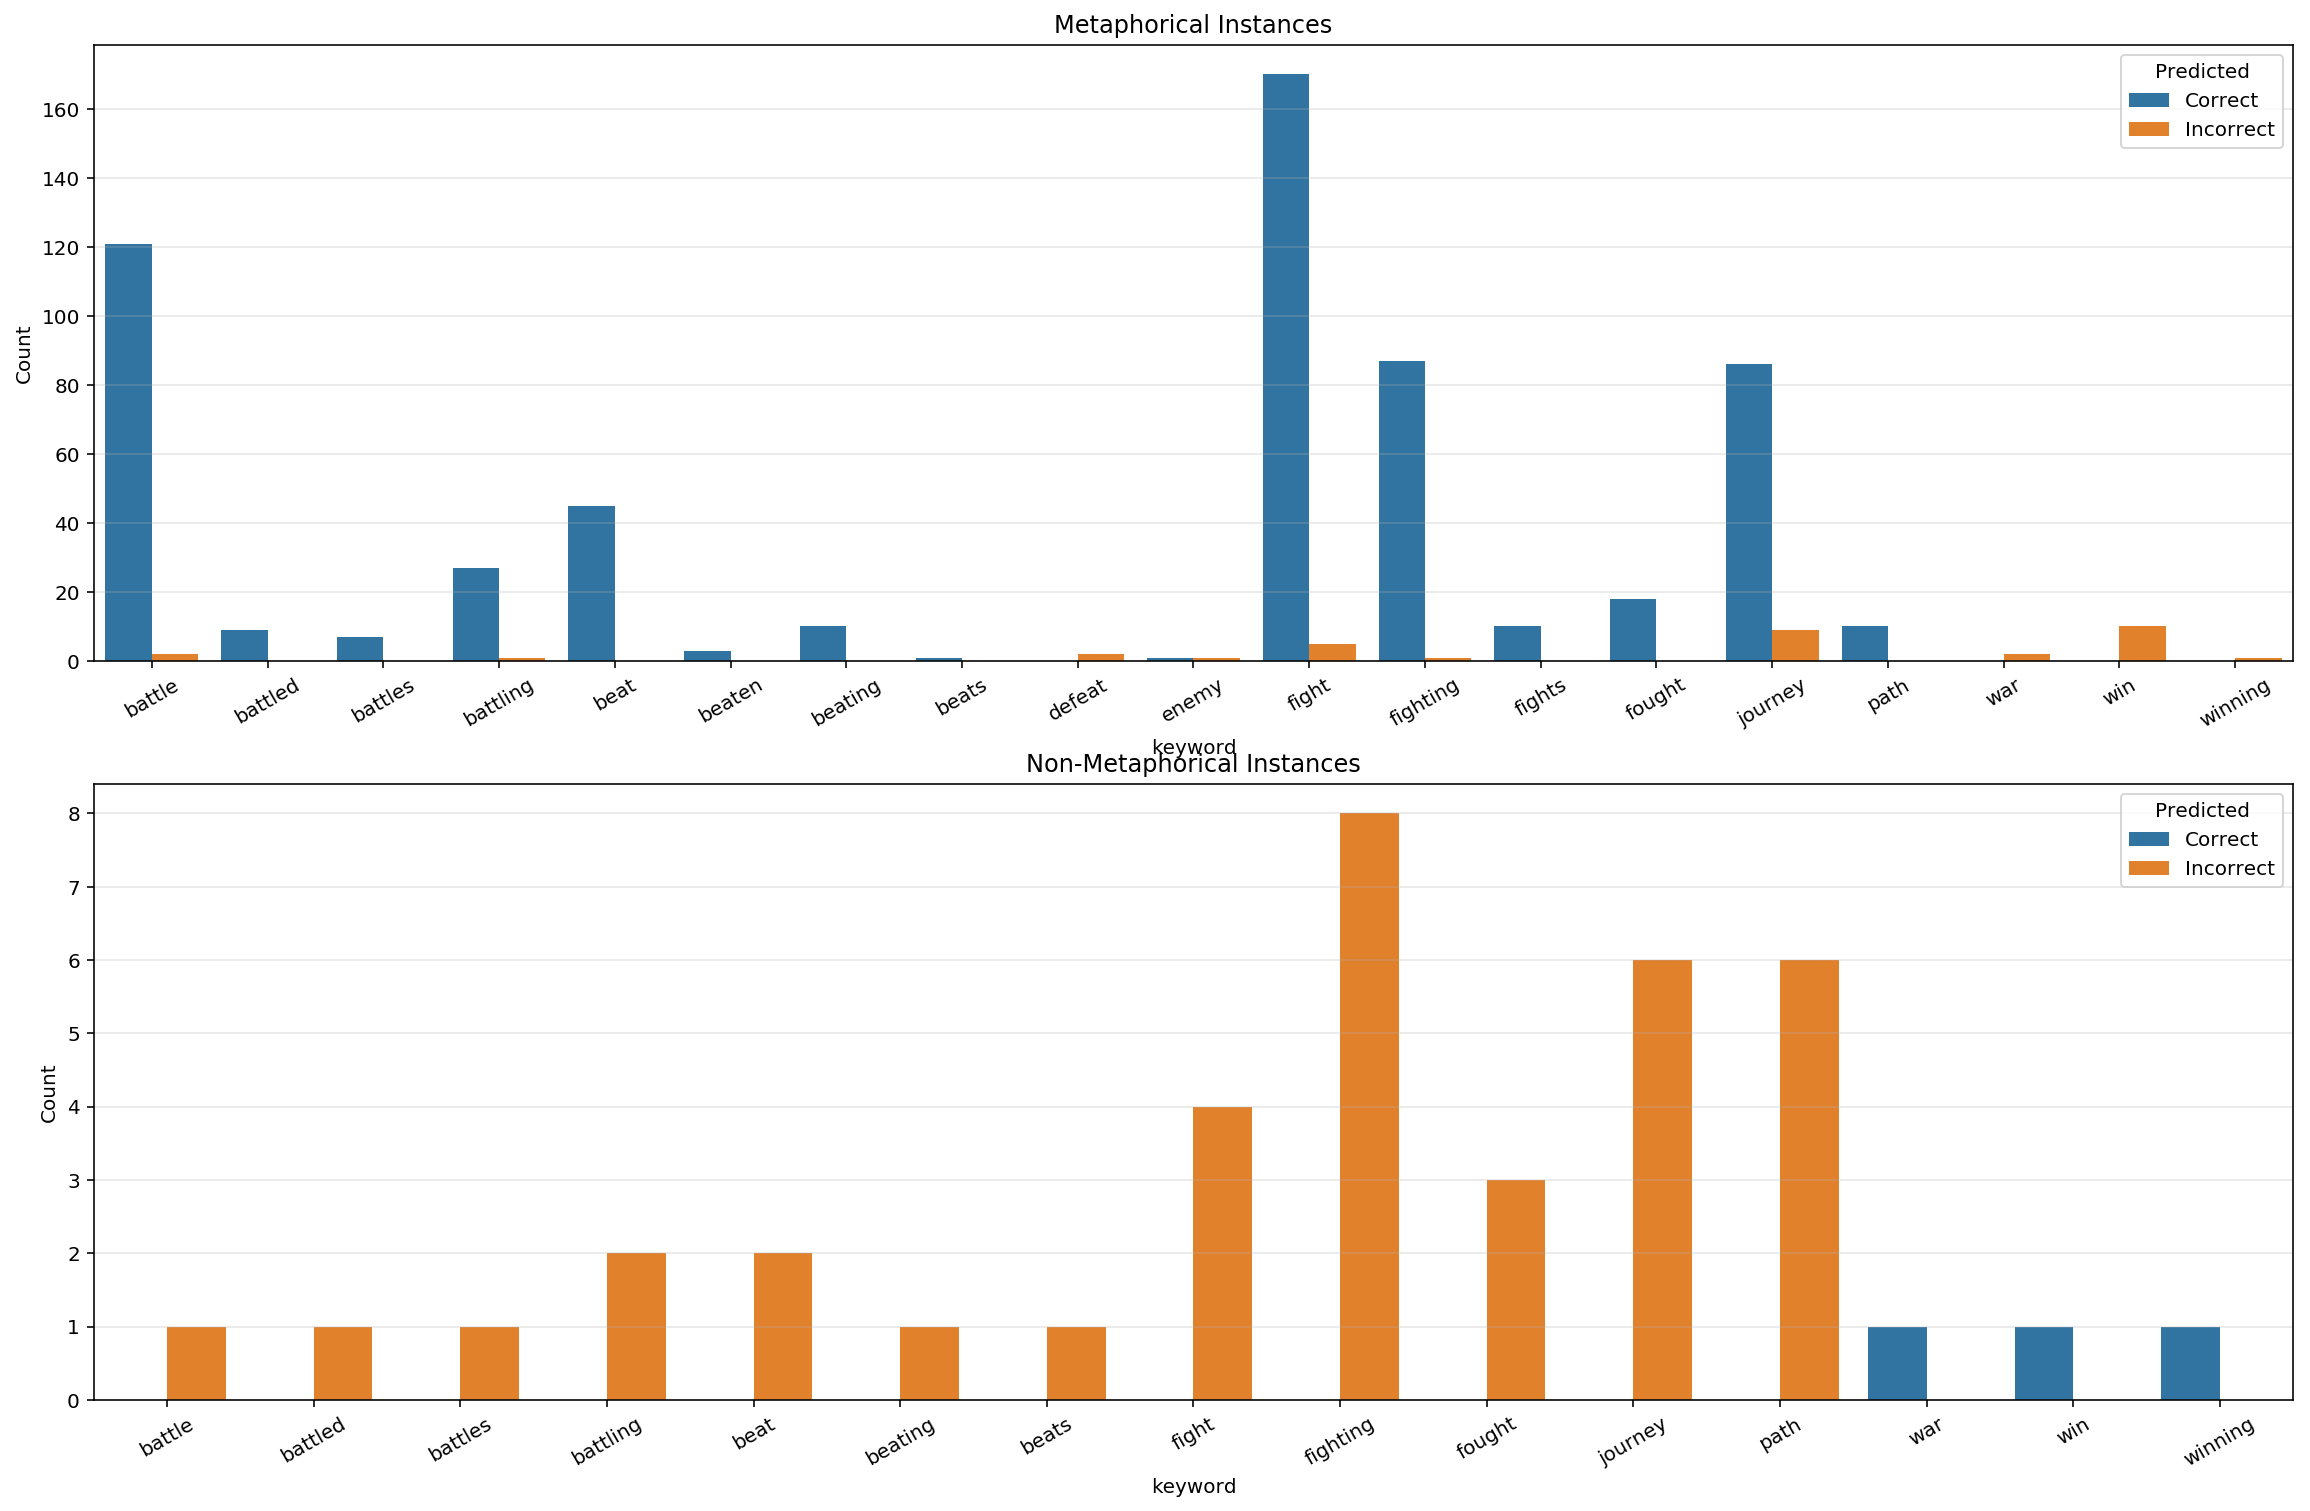

In [14]:
plt.subplots(figsize=(16,10))
plt.tight_layout()

plt.subplot(211)

g = regex_predicted_labeled.loc[regex_predicted_labeled['metaphorical'] == True].groupby('keyword').agg({'predicted': ['sum', 'count']})
s, c = g['predicted']['sum'], g['predicted']['count']

coll = pd.concat({'Correct': s, 'Incorrect': c - s}, axis=0).reset_index()

coll.rename(columns={'level_0': 'Predicted', 0: 'Count'}, inplace=True)

plt.grid(alpha=0.3, axis='y')
plt.title('Metaphorical Instances')
g = sns.barplot(y='Count', x='keyword', hue='Predicted', data=coll)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

plt.subplot(212)

g = regex_predicted_labeled.loc[regex_predicted_labeled['metaphorical'] == False].groupby('keyword').agg({'predicted': ['sum', 'count']})
s, c = g['predicted']['sum'], g['predicted']['count']

coll = pd.concat({'Correct': c - s, 'Incorrect': s}, axis=0).reset_index()

coll.rename(columns={'level_0': 'Predicted', 0: 'Count'}, inplace=True)

plt.grid(alpha=0.3, axis='y')
plt.title('Non-Metaphorical Instances')
g = sns.barplot(y='Count', x='keyword', hue='Predicted', data=coll)
g.set_xticklabels(g.get_xticklabels(), rotation=30);

# Neural Net Detection

In [ ]:
from allennlp.commands.elmo import ElmoEmbedder

from nltk.tokenize import RegexpTokenizer

In [15]:
CANCER_TYPES = ["breast cancer", "lung cancer", "leukemia", "prostate cancer", "melanoma",
                 "lymphoma", "bone cancer", "skin cancer", "bladder cancer", "kidney cancer",
                 "brain cancer", "liver cancer", "pancreatic cancer", "testicular cancer",
                 "colon cancer", "cervical cancer", "esophageal cancer", "neuroblastoma"]

KEYWORDS = ['fights', 'fighting', 'fight', 'fought', 'battles', 'battled', 'battling', 'battle', 'war', 'beating', 'beats', 'beaten', 'beat', 'enemy', 'defeat', 'winning', 'win', 'path', 'journey']

In [16]:
neural_predicted_labeled = labeled_kw_exists.copy().iloc[test_ixs].reset_index(drop=True)
neural_predicted_labeled['predicted'] = False

In [17]:
def make_features_of_instance(ins):
    features = np.zeros(13)

    if "cancer" in ins.fragment.lower():
        features[0] = 1

    toked_prior = tokenizer.tokenize(ins.fragment.lower()[:int(ins.kw_start)])
    toked_post = tokenizer.tokenize(ins.fragment.lower()[int(ins.kw_start):])[1:]

    if "cancer" in toked_prior[-5:] or "cancer" in toked_post[:5]:
        features[1] = 1

    if sum(1 for ct in CANCER_TYPES if ct in ins.fragment.lower()) > 0:
        features[2] = 1

    features[3] = ins.fragment.lower().count('!')
    features[4] = ins.fragment.lower().count('?')
    features[5] = sum(1 for c in ins.fragment if c.isupper())
    features[6] = tokenizer.tokenize(ins.fragment).count('I')
    features[7] = tokenizer.tokenize(ins.fragment.lower()).count('he')
    features[8] = tokenizer.tokenize(ins.fragment.lower()).count('she')
    features[9] = tokenizer.tokenize(ins.fragment.lower()).count('they')
    features[10] = int('treatment' in ins.fragment.lower())
    features[11] = int('odds' in toked_post or 'chance' in toked_post)
    features[12] = len({'bank', 'insurance'} & set(tokenizer.tokenize(ins.fragment.lower())))
    
    features = np.concatenate([features, (np.array(KEYWORDS) == ins.keyword).astype(int)])
    
    return features

def make_features(metaphor):

    data = np.array([make_features_of_instance(ins) for ins in neural_predicted_labeled.itertuples()])
    
    return data

In [18]:
elmo = ElmoEmbedder()
tokenizer = RegexpTokenizer(r'\w+')

In [19]:
def pad(s, kw_start, lim=20):
    '''
    Limit a fragment to `lim` tokens. If less than, pad with empty strings.
    '''
    
    prior = tokenizer.tokenize(s[:kw_start])
    post = tokenizer.tokenize(s[kw_start:])
    
    if len(prior) < lim/2:
        while len(prior) < lim/2:
            prior.insert(0, '')
    else:
        prior = prior[len(prior) - round(lim/2):]
        
    if len(post) < lim/2:
        while len(post) < lim/2:
            post.append('')
    else:
        post = post[:round(lim/2)]
        
    prior.extend(post)
    return prior

In [20]:
features = make_features('battle')

features.shape

(678, 32)

In [21]:
fragments = [pad(fragment.fragment, int(fragment.kw_start)) for fragment in neural_predicted_labeled.loc[:, ['fragment', 'kw_start']].itertuples()] #neural_predicted_labeled['type'] == 'battle'


In [29]:
embds = elmo.embed_sentences(fragments)
embedded_fragments = np.array([embd[2] for embd in tqdm(embds)])

In [30]:
embedded_fragments.shape #, journey_embedded_fragments.shape

(678, 20, 1024)

In [31]:
y_data = neural_predicted_labeled.loc[:, 'metaphorical'].astype(int).values


In [25]:
from keras import backend as K
from keras.models import Model, load_model
from sklearn import metrics

Using TensorFlow backend.


In [26]:
battle_model = load_model('combined_battle_model.h5')
journey_model = load_model('combined_journey_model.h5')

In [32]:
for ix in tqdm(neural_predicted_labeled.index):

    type_ = neural_predicted_labeled.at[ix, 'type']
    
    if type_ == 'battle':
        mod = battle_model
    else:
        mod = journey_model
        
    pred = (mod.predict([[features[ix]], [embedded_fragments[ix]]]) > 0.5).astype(bool)[0][0]
#     print(pred)
    neural_predicted_labeled.at[ix, 'predicted'] = pred

## Results

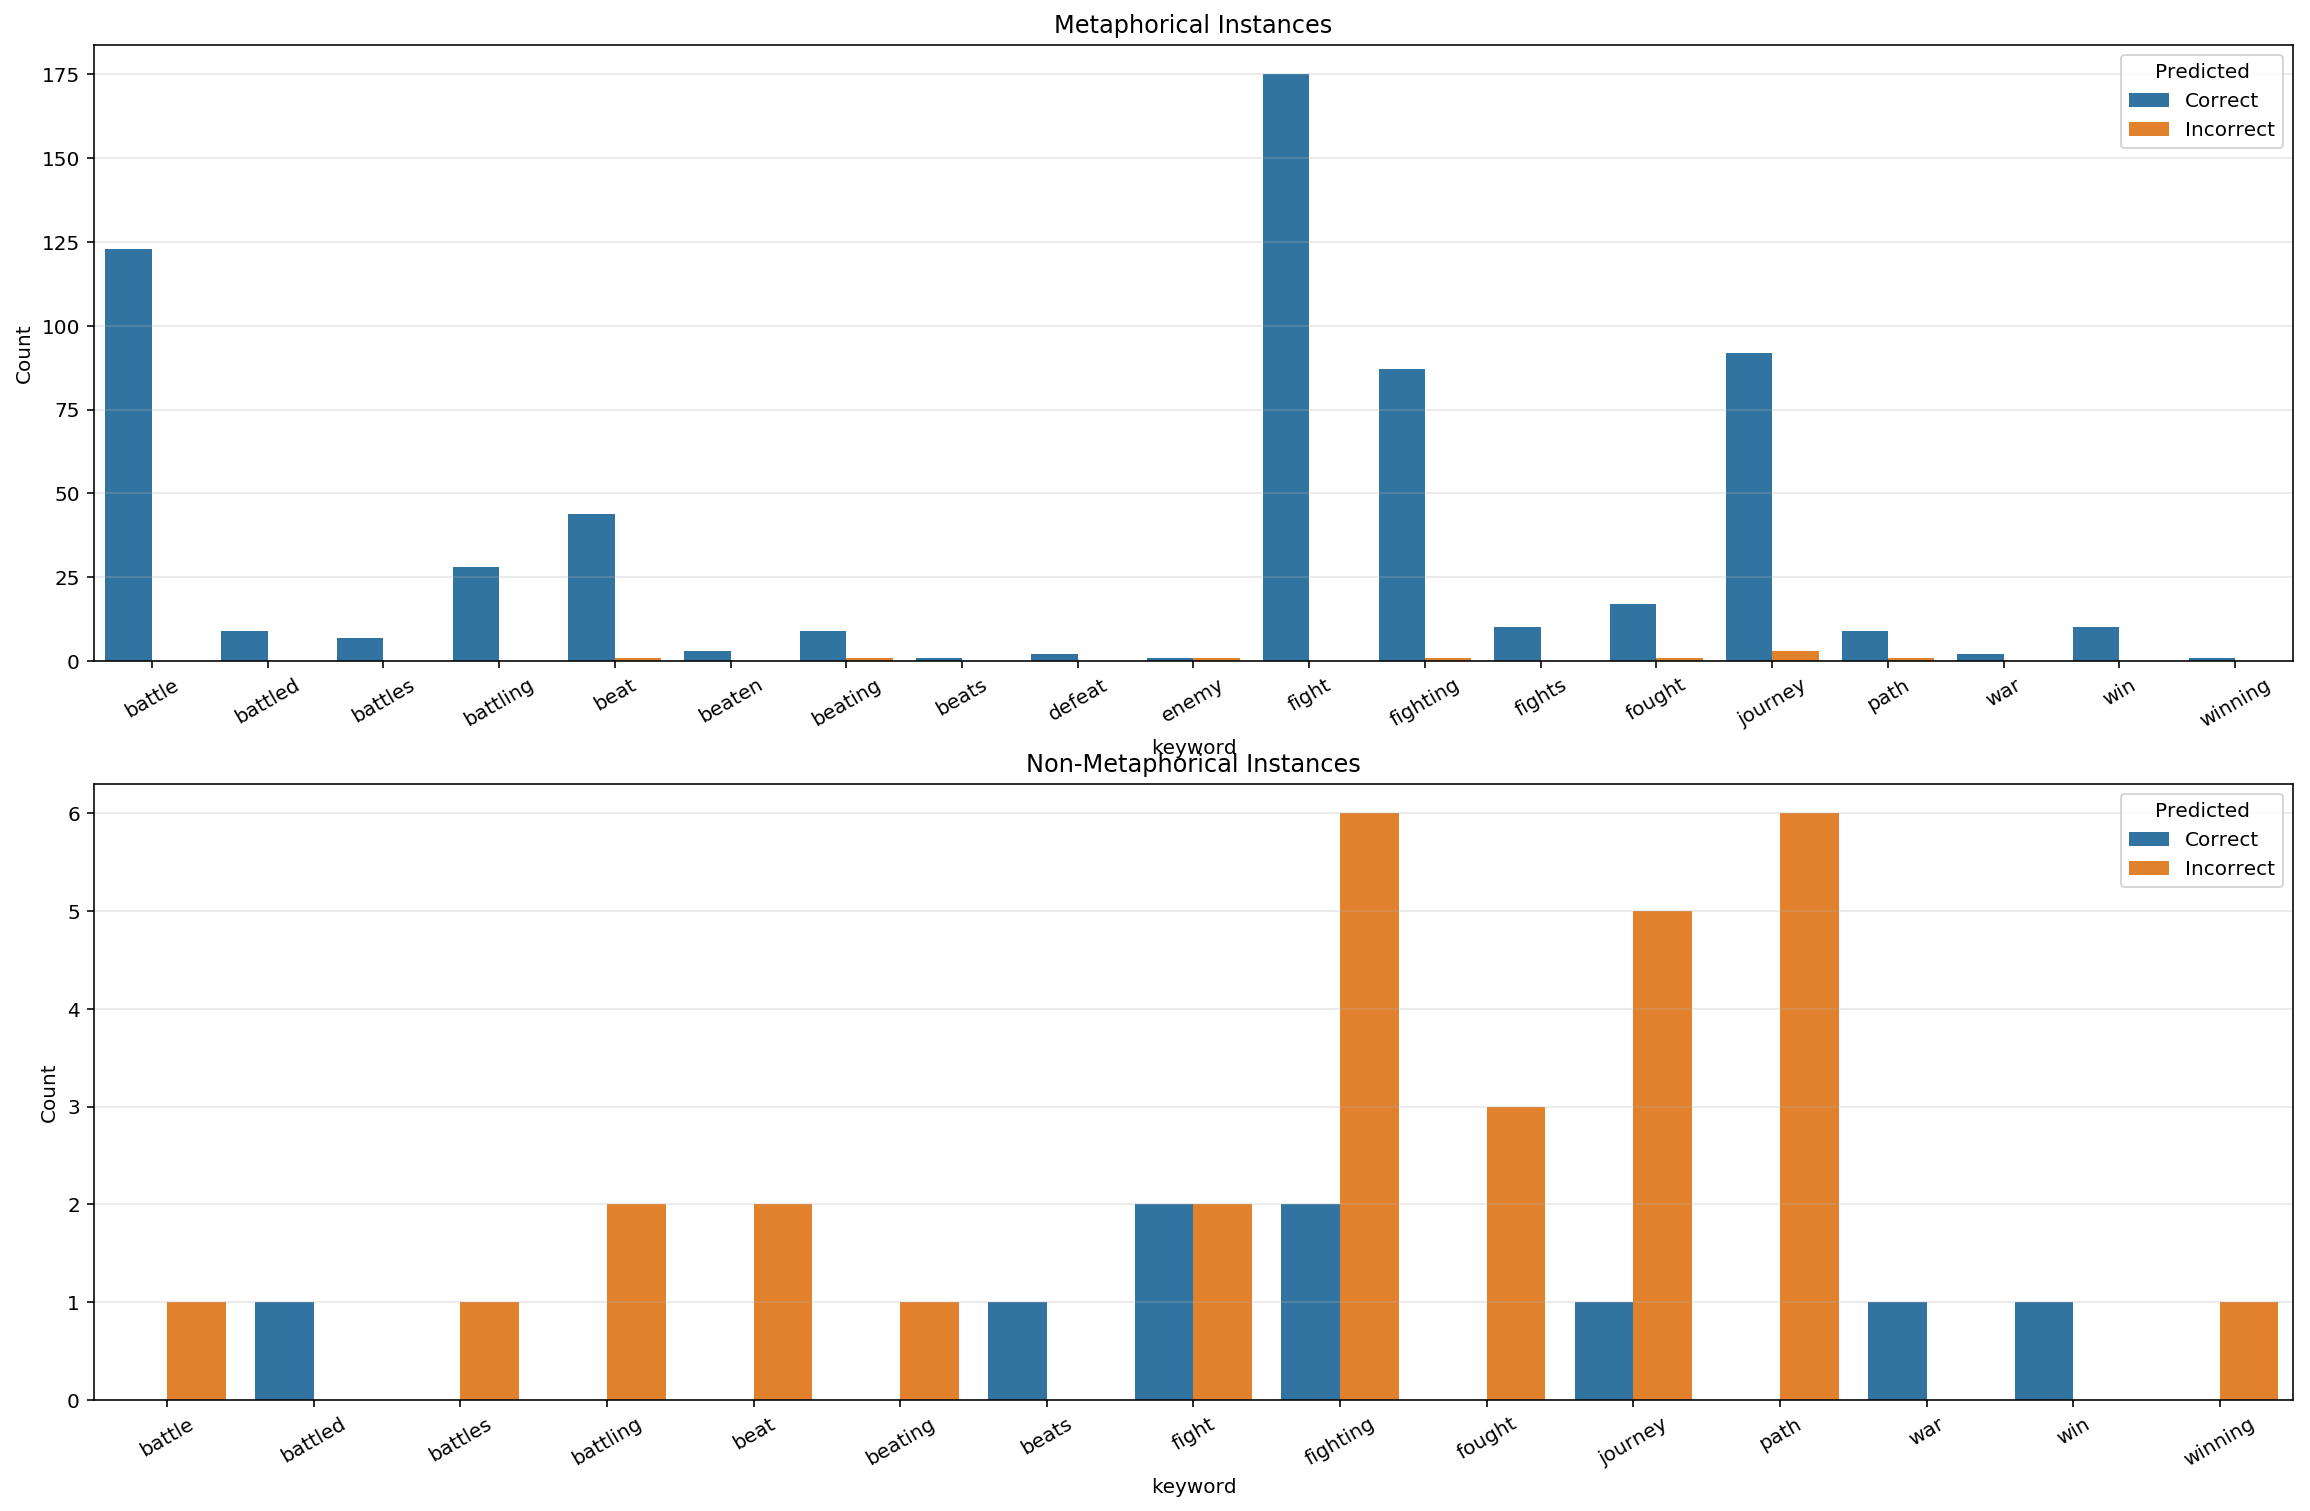

In [33]:
plt.subplots(figsize=(16,10))
plt.tight_layout()

plt.subplot(211)

g = neural_predicted_labeled.loc[neural_predicted_labeled['metaphorical'] == True].groupby('keyword').agg({'predicted': ['sum', 'count']})
s, c = g['predicted']['sum'], g['predicted']['count']

coll = pd.concat({'Correct': s, 'Incorrect': c - s}, axis=0).reset_index()

coll.rename(columns={'level_0': 'Predicted', 0: 'Count'}, inplace=True)

plt.grid(alpha=0.3, axis='y')
plt.title('Metaphorical Instances')
g = sns.barplot(y='Count', x='keyword', hue='Predicted', data=coll)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

plt.subplot(212)

g = neural_predicted_labeled.loc[neural_predicted_labeled['metaphorical'] == False].groupby('keyword').agg({'predicted': ['sum', 'count']})
s, c = g['predicted']['sum'], g['predicted']['count']

coll = pd.concat({'Correct': c - s, 'Incorrect': s}, axis=0).reset_index()

coll.rename(columns={'level_0': 'Predicted', 0: 'Count'}, inplace=True)

plt.grid(alpha=0.3, axis='y')
plt.title('Non-Metaphorical Instances')
g = sns.barplot(y='Count', x='keyword', hue='Predicted', data=coll)
g.set_xticklabels(g.get_xticklabels(), rotation=30);

### Model Comparison

In [274]:
pd.crosstab(regex_predicted_labeled['metaphorical'], regex_predicted_labeled['predicted'], rownames=['Truth'], colnames=['Predicted'], margins=True)

Predicted,False,True,All
Truth,,,
False,7,38,45
True,46,725,771
All,53,763,816


In [275]:
pd.crosstab(neural_predicted_labeled['metaphorical'], neural_predicted_labeled['predicted'], rownames=['Truth'], colnames=['Predicted'], margins=True)

Predicted,False,True,All
Truth,,,
False,19,26,45
True,18,753,771
All,37,779,816


In [276]:
print('Regex Model Cohen\'s Kappa:')
print(f"{metrics.cohen_kappa_score(regex_predicted_labeled['metaphorical'].astype(bool), regex_predicted_labeled['predicted']):.3f}")
print('Neural Model Cohen\'s Kappa:')
print(f"{metrics.cohen_kappa_score(neural_predicted_labeled['metaphorical'].astype(bool), neural_predicted_labeled['predicted']):.3f}")

Regex Model Cohen's Kappa:
0.088
Neural Model Cohen's Kappa:
0.435
